In [386]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import spearmanr, shapiro, pearsonr, ttest_ind, mannwhitneyu, chi2_contingency, kruskal, f_oneway

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder

In [387]:
import warnings
warnings.filterwarnings('ignore')

### Заполнение пропусков и предобработка

In [388]:
df = pd.read_csv('raw_data.csv', skipinitialspace=True, sep=',', index_col=0)
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22.0,NaN,...,0.26,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,0
1,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,40.0,NaN,...,0.12,NaN,NaN,0.0,0.0,NaN,NaN,NaN,84.0,0
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42.0,NaN,...,0.08,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,0
3,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27.0,NaN,...,27.16,NaN,NaN,1.0,1.0,NaN,NaN,NaN,28.9,1
4,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,46.0,NaN,...,63.83,NaN,NaN,1.0,1.0,NaN,NaN,NaN,32.8,0


In [389]:
# обработка сырых данных
# df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
# df['климат'].replace('Cубтроп океанич', 'Cубтропический океанический', inplace=True)
# df['предпочтительное_изменение_температуры'].replace({'Холодн': 'Холоднее', 'Тепле': 'Теплее'}, inplace=True)
# df['режим_при_смешанном_типе_охлаждения'] = df['режим_при_смешанном_типе_охлаждения'].fillna('нет')
# df['способ_обогрева'] = df['способ_обогрева'].fillna('нет')
# df.to_csv('raw_data.csv')

In [390]:
# убираем выбросы через пороговое значение, показания выше которого вызывают вопросы
df = df[df['температура_воздуха_в_помещении'] < 40]
df = df[df['среднемесячная_температура_на_улице'] < 40]
df = df[df['скорость_воздуха'] < 8]

In [391]:
# заполняем возраст по группам из городов
gb = df.groupby('город')['возраст']
md = gb.median()
for city in md.index:
    if not md.isna()[city]:
        df['возраст'][df['город'] == city] = df['возраст'][df['город'] == city].fillna(md[city])
    else:
        df['возраст'][df['город'] == city] = df['возраст'][df['город'] == city].fillna(df['возраст'].median())

In [392]:
# заполняем пол по группам из городов, сохраняя отношение М/Ж в группах
gb = df.groupby('город')['пол']
glbrel = df['пол'].value_counts()['Мужской'] / df['пол'].value_counts()['Женский']
for key, it in gb:
    vc = it.value_counts()
    if vc.size and vc['Мужской'] and vc['Женский']:
        rel = vc['Мужской'] / vc['Женский']
    else:
        rel = glbrel
    ln = len(it)
    f = int(round(ln / (rel + 1)))
    m = ln - f
    df['пол'].fillna({it.index[i]: ('Мужской' if i < m else 'Женский') for i in range(ln)}, inplace=True)

In [393]:
# заполняем рост по возрастным группам
df["возраст"] = df['возраст'].astype(int)
df.loc[df['рост'] <= df['рост'].quantile(0.01), 'рост'] = np.nan
gb1 = df.groupby(['возраст'])['рост']
for key, item in gb1:
    key_mean = gb1.get_group(key).median()
    df["рост"] = df["рост"].fillna(key_mean)

In [394]:
# заполняем вес по возрастным группам
gb2 = df.groupby(['возраст'])['вес']
for key, item in gb2:
    key_mean = gb2.get_group(key).median()
    df["вес"] = df["вес"].fillna(key_mean)

In [395]:
# заполняем занавески, сохраняя отношение есть занавески/нет занавесок
vc = df['занавески'].value_counts()
rel = vc[1] / vc[0]
z = int(round(len(df) / (rel + 1)))
o = ln - z
df['занавески'].fillna({i: (1 if i < o else 0) for i in df.index}, inplace=True)

In [396]:
# заполняем окно и двери, сохраняя отношение есть/нет
def zapolnenie(st2):
    gb = df.groupby(['климат','время_года'])[st2.name]
    dolya = 0
    for group_name, df_group in gb:
        if df_group.isna().sum() == 0:
            dolya_0 = df_group.value_counts()[0.0]/(len(df_group))
            dolya += dolya_0
    dolya = dolya/len(df_group)
    for group_name, df_group in gb:
        if df_group.isna().sum() != 0:
            kolvo_0 = int(round(dolya * len(df_group),0))
            df[st2.name] = df[st2.name].fillna({df_group.index[i]: (0.0 if i < kolvo_0 else 1.0) for i in range(len(df_group))})

zapolnenie(df['окно'])
zapolnenie(df['двери'])
zapolnenie(df['вентилятор'])

In [397]:
# удаление столбца, в котором слишком много пропусков
df.drop('отопление', axis=1, inplace=True)

In [398]:
df.to_csv('corrected_data.csv')

### Работа с корреляциями

In [399]:
df = pd.read_csv('corrected_data.csv', delimiter=',', index_col=0) 
df['год'] = df['год'].astype(str)
df['countmen'] = 1
# Столбец countmen для будущего подсчета людей в каждой группе
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,0.26,170.2,63.0,1.0,1.0,0.0,0.0,28.9,0,1
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,0.08,170.2,63.0,0.0,0.0,0.0,0.0,32.8,0,1
5,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,0.21,170.2,63.0,1.0,1.0,0.0,0.0,28.9,0,1
6,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,0.10,170.2,63.0,1.0,1.0,0.0,0.0,32.8,0,1
8,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,0.15,170.2,63.0,1.0,1.0,0.0,0.0,32.8,0,1


In [400]:
# Шкалы всех столбцов для последующей корреляции
types = {
    # 'год': 'cat',
    'город': 'cat',
    # 'страна': 'cat',
    'возраст': 'num',
    # 'пол': 'cat',    
    'утепление':'num',    
    'количество_рекламаций': 'num',
    'время_года': 'cat', 
    'климат': 'cat', 
    'способ_охлаждения': 'cat', 
    # 'режим_при_смешанном_типе_охлаждения': 'cat', 
    'способ_обогрева': 'cat', 
    # 'температура_воздуха_в_помещении': 'num',     
    'rh': 'num', 
    'скорость_воздуха': 'num', 
    # 'занавески': 'cat',
    'вентилятор': 'num',
    # 'окно': 'cat', 
    # 'двери': 'cat', 
    'среднемесячная_температура_на_улице': 'num'}
subs = {'ощущение_температуры': 'cat',        
    'ощущение_температуры_(bool)': 'cat',
    'предпочтительное_изменение_температуры': 'cat',
    # 'ощущение_движения_воздуха_(bool)': 'cat',
    'предпочтительное_изменение_движения_воздуха': 'cat',
    'оценка_комфорта': 'cat'}

# Создание функций для добавления категориальных столбцов датафрейма
def changerecl(x):
    if x <= 1:
        return 'мало'
    if x == 2:
        return 'средне'
    if x > 2:
        return 'много'
    
def changeage(x):
    if x <= 44:
        return 'молодой возраст'
    if 45 <= x <= 59:
        return 'средний возраст'
    if x >= 60:
        return 'пожилой возраст'
def standr_comf_rh(df):
    if 40 <= df['rh'] <= 60:
        return 'OK'
    else:
        return 'not OK'
# Функции для выполнения корреляций

#реализация хи-квадрат
def hi2(g1, g2):
    ct = pd.crosstab(g1, g2)
    chi2 = chi2_contingency(ct)
    return (chi2.statistic / (df.shape[0] * (min(df.shape) - 1))) ** 0.5, chi2.pvalue

# функция, которая вычисляет корреляцию и p-уровень между двумя факторами, на основе их типа
def corr(g1, g2, type1, type2):
    res = 0
    # разные шкалы
    if type1 != type2:
        norm = 0
        if type1 == 'cat':
            norm = shapiro(g2).pvalue >= 0.05 # проверка на нормальность
            gs = [g2[g1 == i] for i in g1.unique()] # разбиение по группам для случаев, когда у категориального фактора больше 2 уровней
            ln = len(g1.unique())
        else:
            gs = [g1[g2 == i] for i in g2.unique()] # разбиение по группам для случаев, когда у категориального фактора больше 2 уровней
            norm = shapiro(g1).pvalue >= 0.05 # проверка на нормальность
            ln = len(g2.unique())
        if not norm:
            if ln == 2:
                res = mannwhitneyu(*gs)
                method = 0
            else:
                res = kruskal(*gs)
                method = 1
        else: 
            if ln == 2:
                res = ttest_ind(*gs)
                method = 2
            else:
                res = f_oneway(*gs)
                method = 3
    else: #одинаковые шкалы
        if type1 == 'cat':
            method = 4
            res = hi2(g1, g2)
        else:
            norm = shapiro(g1).pvalue >= 0.05 and shapiro(g2).pvalue >= 0.05 # проверка на нормальность
            if not norm:
                res = spearmanr(g1, g2)
                method = 5
            else:
                res = pearsonr(g1, g2)
                method = 6
    return res[0], res[1], method

In [401]:
# Категоризация требуемых данных в отдельных столбцах
df['реклам_категория'] = df['количество_рекламаций'].map(changerecl)
df['возрастная_категория'] = df['возраст'].map(changeage)
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст
5,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
6,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст
8,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст


In [402]:
dfmeanage = df[['пол', 'страна', 'возраст']].groupby(['пол', 'страна']).mean().round().astype(int)
dfmeanage.head()
# Рассчитать средний возраст респондентов по полу и стране

возраст
пол     страна            
Женский Австралия       46
        Индия           35
        США             38
Мужской Австралия       43
        Индия           37

In [403]:
goodtemp = df.loc[df['предпочтительное_изменение_температуры'] == 'Без изменений']
goodtemp.head()
# Сбор всех данных с комфортной температурой

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций,countmen,реклам_категория,возрастная_категория
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст
5,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,63.0,1.0,1.0,0.0,0.0,28.9,0,1,мало,молодой возраст
8,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,63.0,1.0,1.0,0.0,0.0,32.8,0,1,мало,молодой возраст
12,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,63.0,0.0,0.0,0.0,0.0,32.8,0,1,мало,молодой возраст


In [404]:
dfcomftemp = goodtemp[['температура_воздуха_в_помещении', 'возрастная_категория']].groupby('возрастная_категория').mean().round(1)
dfcomftemp.head()
# Рассчитать среднюю комфортную температуру в зависимости от возрастной категории

,температура_воздуха_в_помещении
возрастная_категория,
молодой возраст,24.7
пожилой возраст,25.4
средний возраст,24.5


In [405]:
df3 =  goodtemp[['страна', 'пол', 'countmen']].groupby(['страна', 'пол']).count()
df3.reset_index(inplace=True)
for i in range(len(df3)):
    df3['countmen'][i] = round(df3['countmen'][i] / len(df.loc[(df['страна'] == df3['страна'][i]) & (df['пол'] == df3['пол'][i])]) * 100)

df3.head()
# Добавить столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола

,страна,пол,countmen
0,Австралия,Женский,57
1,Австралия,Мужской,78
2,Индия,Женский,49
3,Индия,Мужской,57
4,США,Женский,53


In [406]:
dftypeohl = df[['способ_охлаждения', 'температура_воздуха_в_помещении', 'rh']].groupby('способ_охлаждения').median()
dftypeohl.head()
# Рассчитать медианное значение температуры и влажности для каждого типа охлаждения 

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,25.30,46.3
Кондиционирование,24.35,43.7
Смешанный,24.65,56.4


In [407]:
pivot = pd.pivot_table(df, index=['страна', 'пол', 'возрастная_категория'], values=['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh'], 
                       aggfunc='mean').round(2)
pivot.head()
'''
Составить сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе 
и подсчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп.
'''


'\nСоставить сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе \nи подсчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп.\n'

In [408]:
df['стандр_комф_вл'] = df.apply(standr_comf_rh, axis=1)
df.head()
''' 
Самостоятельно найти информацию по стандартной комфортной относительной влажности в помещениях (в нашем случае - офисы). 
Создать новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет. 
Категории назначить самостоятельно.
'''

' \nСамостоятельно найти информацию по стандартной комфортной относительной влажности в помещениях (в нашем случае - офисы). \nСоздать новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет. \nКатегории назначить самостоятельно.\n'

<Axes: >

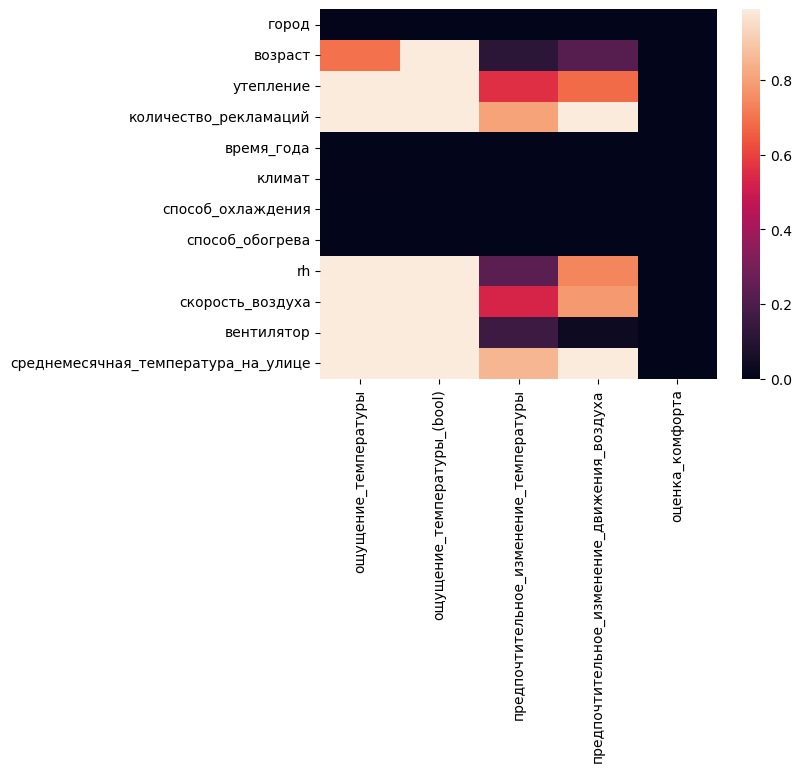

In [409]:
# составляем хитмап корреляций
cols = list(types)
colssubs = list(subs)
resflat = []
res = np.zeros((len(cols), len(colssubs)), dtype='float32')
meths = np.zeros_like(res, dtype='O')
for i in range(len(cols)):
    for j in range(len(colssubs)):
        f1, f2 = cols[i], colssubs[j]
        statistics, pvalue, meth = corr(df[f1], df[f2], types[f1], subs[f2])
        res[i, j] = statistics
        meths[i, j] = meth
        if pvalue < 0.05 and statistics > 0.5:
            resflat.append([f1 + ' ' + f2, statistics, pvalue, meth])
for meth in np.unique(meths):
    idx = meths == meth
    if meth <= 4:
        g = res[idx]
        for i in range(len(g)):
            if g[i] == np.nan:
                g[i] = 0
            elif g[i] >= 20:
                g[i] = 0.99
            else:
                g[i] = g[i] / 20
        res[idx] = g
dfress = pd.DataFrame(index=cols, columns=colssubs, data=res)
sns.heatmap(dfress.fillna(0))

### Проверка гипотез

In [410]:
df = pd.read_csv('corrected_data.csv', skipinitialspace=True, sep=',', index_col=0)
df.head()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,rh,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,среднемесячная_температура_на_улице,количество_рекламаций
0,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,22,Мужской,...,48.9,0.26,170.2,63.0,1.0,1.0,0.0,0.0,28.9,0
2,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,42,Мужской,...,34.7,0.08,170.2,63.0,0.0,0.0,0.0,0.0,32.8,0
5,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,27,Мужской,...,34.8,0.21,170.2,63.0,1.0,1.0,0.0,0.0,28.9,0
6,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,32,Мужской,...,42.2,0.10,170.2,63.0,1.0,1.0,0.0,0.0,32.8,0
8,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,нет,нет,43,Мужской,...,34.7,0.15,170.2,63.0,1.0,1.0,0.0,0.0,32.8,0


In [411]:
corr(df['способ_охлаждения'], df['оценка_комфорта'], 'cat', 'cat')

(0.04383521861198591, 0.3225687848299498, 4)

Способ охлаждения не вляет на оценку комфорта. Значение корреляции маленькое, следовательно, зависимость очень слабая. Уровень доверия больше 0.05, значит, ответу нельзя доверять.

In [412]:
corr(df['пол'], df['оценка_комфорта'], 'cat', 'cat')

(0.025069087652918227, 0.7127152082008428, 4)

Здесь уровень корреляции также маленький, однако p-уровень больше 0.05, поэтому по имеющимся данным выводов мы делать не можем

In [413]:
df['возрастная_категория'] = df['возраст'].map(changeage)
corr(df['возрастная_категория'], df['оценка_комфорта'], 'cat', 'cat')

(0.0448348817563558, 0.2298590866347347, 4)

Здесь уровень корреляции также маленький, однако p-уровень больше 0.05, поэтому по имеющимся данным выводов мы делать не можем

In [414]:
corr(df['количество_рекламаций'], df['оценка_комфорта'], 'num', 'cat')

(nan, nan, 1)

Здесь, к сожалению, не удалось подсчитать корреляцию, так как слишком много пропусков

In [415]:
corr(df['страна'], df['оценка_комфорта'], 'cat', 'num') 

(nan, nan, 3)

Здесь, к сожалению, не удалось подсчитать корреляцию, так как слишком много пропусков

### Построение регрессионной модели

In [416]:
import warnings
warnings.filterwarnings('ignore')

In [417]:
df = pd.read_csv('corrected_data.csv', skipinitialspace=True, sep=',', index_col=0)

In [418]:
# здесь слишком много пропусков
df.drop('температура_воздуха_на_улице', axis=1, inplace=True)

In [419]:
# столбцы, которые могут влиять на температуру воздуха в помещении
factors_list = ['время_года', 
         'климат', 
         'способ_охлаждения', 
         'режим_при_смешанном_типе_охлаждения', 
         'температура_воздуха_в_помещении',
         'способ_обогрева', 
         'rh', 
         'скорость_воздуха', 
         'занавески', 
         'вентилятор', 
         'окно', 
         'двери', 
         'среднемесячная_температура_на_улице']
factors = df[factors_list]

In [420]:
# шкалы этих столбцов
types = {
    'время_года': 'cat', 
    'климат': 'cat', 
    'способ_охлаждения': 'cat', 
    'режим_при_смешанном_типе_охлаждения': 'cat', 
    'способ_обогрева': 'cat', 
    'температура_воздуха_в_помещении': 'num', 
    'температура_воздуха_на_улице': 'num', 
    'rh': 'num', 
    'скорость_воздуха': 'num', 
    'занавески': 'cat',
    'вентилятор': 'cat', 
    'окно': 'cat', 
    'двери': 'cat', 
    'среднемесячная_температура_на_улице': 'num'
}

In [421]:
# функция, делающая график зависимости двух факторов на основе их типа
def get_plot(col1, col2, type1, type2, i, j):
    global ax
    # если разные шкалы - боксплот
    if type1 != type2:
        if type1 == 'cat':
            sns.boxplot(x=col1, y=col2, ax=ax[i, j])
        else:
            sns.boxplot(x=col2, y=col1, ax=ax[i, j])
    else: # иначе, т.к. одна из шкал - температура, то есть количественная, - скаттерплот
        sns.scatterplot(x=col1, y=col2, ax=ax[i, j], legend=False)

In [422]:
# применяем label encode к климату, так проще визуализировать на графике
unq = factors['климат'].unique()
enc = {unq[i]: i for i in range(len(unq))}
factors['климат'] = factors['климат'].apply(lambda x: enc[x])

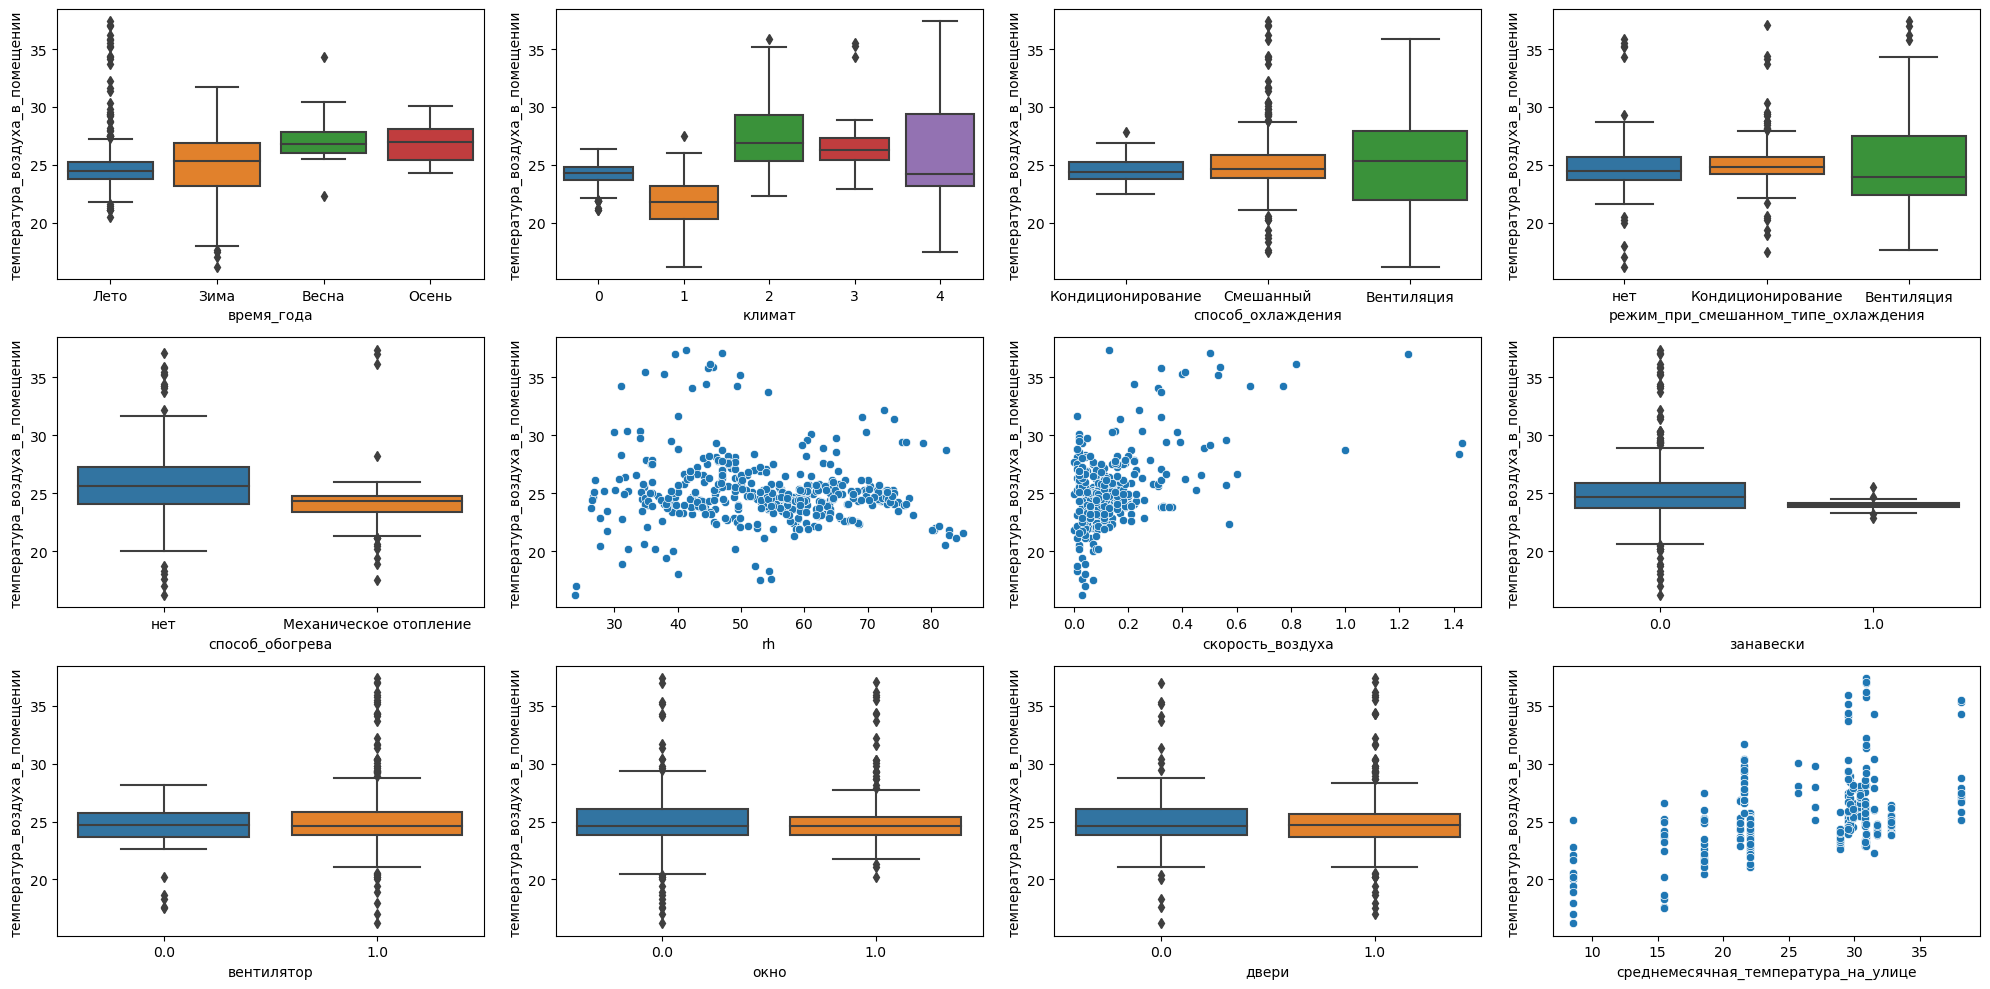

In [423]:
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
i = 0
for col in factors.columns:
    if col != 'температура_воздуха_в_помещении':
        get_plot(factors[col], df['температура_воздуха_в_помещении'], types[col], types['температура_воздуха_в_помещении'], i // 4, i % 4)
        i += 1
fig.tight_layout()

In [424]:
res = []
f2 = 'температура_воздуха_в_помещении'
for i in range(len(factors_list)):
    f1 = factors_list[i]
    if f1 != f2:
        res.append([*corr(factors[f1], factors[f2], types[f1], types[f2]), f1])
res.sort(key=lambda x: x[1] if x[1] < 0.05 else 1e9, reverse=False)
res

[[182.0219169567037, 2.743358059798561e-38, 1, 'климат'],
 [0.42179035551304545,
  4.718815884032914e-21,
  5,
  'среднемесячная_температура_на_улице'],
 [37698.0, 2.9537861270668604e-17, 0, 'способ_обогрева'],
 [36.66660650218179, 5.412737559554017e-08, 1, 'время_года'],
 [0.21627819420018726, 3.225685409526806e-06, 5, 'скорость_воздуха'],
 [3154.5, 0.0012914470540354307, 0, 'занавески'],
 [10.914894905080471,
  0.004264427016542392,
  1,
  'режим_при_смешанном_типе_охлаждения'],
 [-0.10508359632844205, 0.024990261116553867, 5, 'rh'],
 [3.0997698469121837, 0.2122723999954351, 1, 'способ_охлаждения'],
 [11065.0, 0.7934141651624057, 0, 'вентилятор'],
 [24187.0, 0.911866619920265, 0, 'окно'],
 [26239.5, 0.7912730284858436, 0, 'двери']]

In [425]:
# выделяем те факторы, влияние которых наибольшее
x = df[['время_года', 'климат', 'способ_обогрева', 'среднемесячная_температура_на_улице', 'вентилятор', 'скорость_воздуха']]
y = df['температура_воздуха_в_помещении']

In [426]:
# применяем энкодинг к категориальным столбцам
for col in x.columns:
    if x[col].dtype not in ['float', 'int']:
        enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        x[(col + ': ' + x[col].unique()).tolist()] = enc.fit_transform(x[[col]])
        x.drop(col, axis=1, inplace=True)

In [427]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [428]:
# строим модель и проверяем её эффективность
reg = LinearRegression()
reg.fit(x_train, y_train)
reg.score(x_test, y_test)

0.6486053901517743

In [429]:
mse(y_test, reg.predict(x_test)) ** 0.5

1.8124064203743941

In [430]:
# сохраняем модель
from joblib import dump, load
dump(reg, 'models/regressor_without_temp.joblib')

['models/regressor_without_temp.joblib']

In [431]:
# загружаем модель
reg = load('models/regressor_without_temp.joblib')